In [12]:
from sansdata import *

In [13]:
sans_file = SansData(f"data/perspex_Q4.mpa")

def plot_image(data, label):
    plt.figure()
    # extent = [550//2, 1024-550//2, 550//2, 1024-550//2]
    extent = [0,1024,0,1024]
    plt.imshow(
        data, cmap="viridis", extent=extent, aspect="auto"
    ) 
    plt.colorbar(label=label)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid()
    plt.show()

## Characterize active detector region dimensions

Min x, y: (233, 232)
Max x, y: (800, 799)
Centre x,y: (516.5, 515.5)
Active pixels W x H: 568 x 568


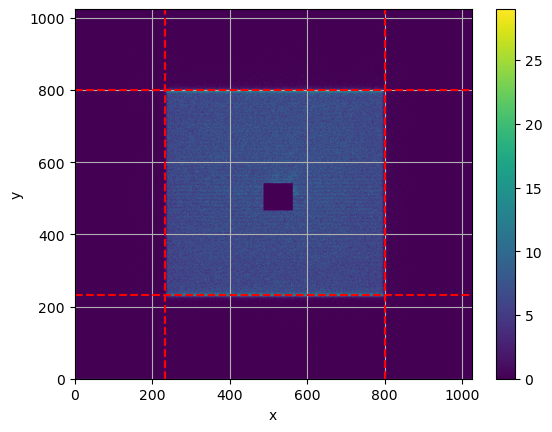

In [14]:
# Helper function for indexing a rectangle from an array
def rect_slice(center, size):
    x, y = center
    return (slice(y - size // 2, y + size // 2), slice(x - size // 2, x + size // 2))

N_eff_pixel = 540  # just an estimate for now
beamstop_x, beamstop_y = 1024 - 500, 520
beamstop_w, beamstop_h = 76, 76
flood_intensities_full = sans_file.raw_intensity.astype(float)
flood_intensities_full[rect_slice((beamstop_x, beamstop_y),beamstop_w)] = 0
flood_intensities = flood_intensities_full
nonzero_indices = np.argwhere(flood_intensities_full >= 6)


min_x, min_y = nonzero_indices.min(axis=0)
max_x, max_y = nonzero_indices.max(axis=0)
min_x += 18
max_x += 4
max_x -= 2
min_y -= 2
centre_x = (max_x + min_x)/2
centre_y = (max_y + min_y)/2
w =max_x - min_x + 1
h = max_y - min_y + 1
print(f"Min x, y: ({min_x}, {min_y})")
print(f"Max x, y: ({max_x}, {max_y})")
print(f"Centre x,y: ({centre_x}, {centre_y})")
print(f"Active pixels W x H: {w} x {h}")

plt.figure()
# extent = [550//2, 1024-550//2, 550//2, 1024-550//2]
extent = [0,1024,0,1024]
plt.imshow(
    flood_intensities_full, cmap="viridis", extent=extent, aspect="auto"
) 
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.axvline(min_x, color='red', linestyle='--')
plt.axvline(max_x, color='red', linestyle='--')
plt.axhline(min_y, color='red', linestyle='--')
plt.axhline(max_y, color='red', linestyle='--')
plt.grid()
plt.show()

## Compute pixel sizes and locations

In [15]:
W_eff = 0.60 # m
N_pixels_eff = w
pixel_size = W_eff / N_pixels_eff # m
print(f"Pixel size: {pixel_size} m")
half_pixel = pixel_size / 2
print(f"Half pixel size: {half_pixel} m")
N_pixels = w
W = pixel_size * N_pixels
print(f"Full width: {W} m")

Pixel size: 0.001056338028169014 m
Half pixel size: 0.000528169014084507 m
Full width: 0.6 m


In [16]:
# Compute pixel centers
def compute_unit_centers(width, unit_width, unit_count):
    return unit_width/2 + np.arange(0,unit_count) * unit_width - width/2
pixel_x = compute_unit_centers(W,pixel_size, N_pixels_eff)
pixel_x

array([-0.29947183, -0.29841549, -0.29735915, -0.29630282, -0.29524648,
       -0.29419014, -0.2931338 , -0.29207746, -0.29102113, -0.28996479,
       -0.28890845, -0.28785211, -0.28679577, -0.28573944, -0.2846831 ,
       -0.28362676, -0.28257042, -0.28151408, -0.28045775, -0.27940141,
       -0.27834507, -0.27728873, -0.27623239, -0.27517606, -0.27411972,
       -0.27306338, -0.27200704, -0.2709507 , -0.26989437, -0.26883803,
       -0.26778169, -0.26672535, -0.26566901, -0.26461268, -0.26355634,
       -0.2625    , -0.26144366, -0.26038732, -0.25933099, -0.25827465,
       -0.25721831, -0.25616197, -0.25510563, -0.2540493 , -0.25299296,
       -0.25193662, -0.25088028, -0.24982394, -0.24876761, -0.24771127,
       -0.24665493, -0.24559859, -0.24454225, -0.24348592, -0.24242958,
       -0.24137324, -0.2403169 , -0.23926056, -0.23820423, -0.23714789,
       -0.23609155, -0.23503521, -0.23397887, -0.23292254, -0.2318662 ,
       -0.23080986, -0.22975352, -0.22869718, -0.22764085, -0.22

## Generate instrument definition file from template

In [17]:
file_path = 'RIDSANS_Definition_template.xml'

with open(file_path, 'r') as file:
    file_content = file.read()
# print(file_content)

In [18]:
value_map = {
    "PIXEL_SIZE": pixel_size,
    "HALF_PIXEL_SIZE": half_pixel,
    "PIXEL_START_X": pixel_x[0],
    "PIXEL_START_Y": pixel_x[0],
    "DETECTOR_PIXELS_X": N_pixels_eff,
    "DETECTOR_PIXELS_Y": N_pixels_eff,
}
for (k,v) in value_map.items():
    file_content=file_content.replace("$" + k,str(v))
file_content

'<?xml version=\'1.0\' encoding=\'ASCII\'?>\n<instrument xmlns="http://www.mantidproject.org/IDF/1.0"\n\t    xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"\n\t    name="RIDSANS"\n\t    valid-from="2024-10-22 00:00:00"\n\t    valid-to="2110-10-10 10:13:12"\n\t    last-modified="2024-10-22 13:50:00.000000"\n\t    xsi:schemaLocation="http://www.mantidproject.org/IDF/1.0 http://schema.mantidproject.org/IDF/1.0/IDFSchema.xsd">\n  <!--Created by Thom van der Woude, tbvanderwoude@protonmail.com-->\n  <defaults>\n    <length unit="metre"/>\n    <angle unit="degree"/>\n    <reference-frame>\n      <along-beam axis="z"/>\n      <pointing-up axis="y"/>\n      <handedness val="right"/>\n    </reference-frame>\n    <default-view view="3D" axis-view="Z-"/>\n  </defaults>\n\n  <component type="moderator">\n    <location z="-13.601"/>\n  </component>\n  <type name="moderator" is="Source"/>\n\n  <component type="sample-position">\n    <location x="0.0" y="0.0" z="-5.0"/>\n  </component>\n  <type

In [19]:
file_path = 'RIDSANS_Definition.xml'

with open(file_path, 'w') as file:
    file.write(file_content)

## Instrument definition loading test

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from mantid.simpleapi import *

# create sample workspace
ws1 = CreateSampleWorkspace();
inst1 = ws1.getInstrument();
print("Default workspace has instrument: {0} with {1} parameters".format(inst1.getName(),len(inst1.getParameterNames())))
ws2 = CreateSampleWorkspace();
mon2 = LoadInstrument(ws2, FileName="RIDSANS_Definition.xml", RewriteSpectraMap=True)
inst2 = ws2.getInstrument()
di2 = ws2.detectorInfo()
ci2 = ws2.componentInfo()
print("Workspace {0} has instrument: {1}".format(ws2.name(), inst2.getName()))
print("Instrument {0} has {1} components, including {2} monitors and {3} detectors".format(inst2.getName(), ci2.size(), len(mon2), di2.size()))

FrameworkManager-[Notice] Welcome to Mantid 6.10.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.10
CheckMantidVersion-[Notice] A new version of Mantid(6.11.0) is available for download from https://download.mantidproject.org
DownloadInstrument-[Notice] All instrument definitions up to date
CreateSampleWorkspace-[Notice] CreateSampleWorkspace started
Default workspace has instrument: basic_rect with 0 parameters
CreateSampleWorkspace-[Notice] CreateSampleWorkspace successful, Duration 0.00 seconds
CreateSampleWorkspace-[Notice] CreateSampleWorkspace started
CreateSampleWorkspace-[Notice] CreateSampleWorkspace successful, Duration 0.00 seconds
LoadInstrument-[Notice] LoadInstrument started
InstrumentDefinitionParser-[Notice] Geometry cache is not available
InstrumentDefinitionParser-[Notice] Creating cache in /home/tbvanderwoude/.mantid/instrument/geometryCache/RIDSANS5cb9341954f8967938a47

## Compute relative pixel efficiencies from perspex measurement
Note: the [DetectorFloodWeighting](https://docs.mantidproject.org/nightly/algorithms/DetectorFloodWeighting-v1.html) algorithm appears to do the same and uses the mean technique rather than an absolute.

Mean factor: 0.2698603966620941, mean error 0.10237601523864746


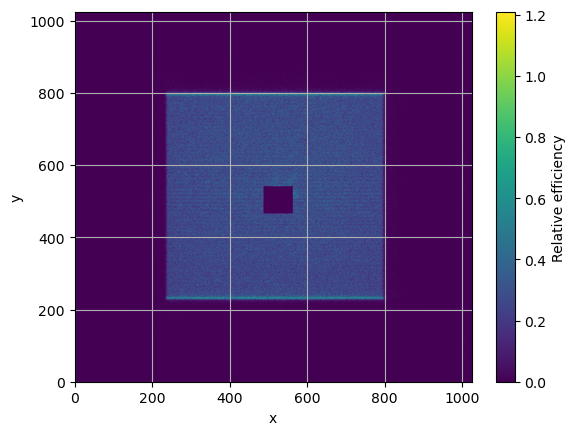

In [20]:
# Compute pixel efficiency from flood measurement
relative_efficiency = False
if relative_efficiency:
    # Compensate for the fact that the beamstop square is not considered in the average
    area_factor = 1/(1- beamstop_w * beamstop_h/N_eff_pixel ** 2)
    print(area_factor)

    # Idea: compute relative pixel efficiency based on the average pixel counts over the given area
    mu_flood = np.mean(flood_intensities[rect_slice((512, 512), N_eff_pixel)]) * area_factor
    flood_norm = flood_intensities / mu_flood
else:
    # This assumes that the best pixel has efficiency 1? Also not ideal
    max_intensity = np.max(flood_intensities[rect_slice((512, 512), N_eff_pixel)])
    flood_norm = flood_intensities / max_intensity
    dflood_norm = np.sqrt(flood_intensities) / max_intensity
    # flood_norm[flood_norm<=0] = 1
    print(f"Mean factor: {np.mean(flood_norm[rect_slice((512, 512), N_eff_pixel)])}, mean error {np.mean(dflood_norm[rect_slice((512, 512), N_eff_pixel)])}")

plot_image(flood_norm, "Relative efficiency")

## Plot integrals along $x,y$ to see relevance

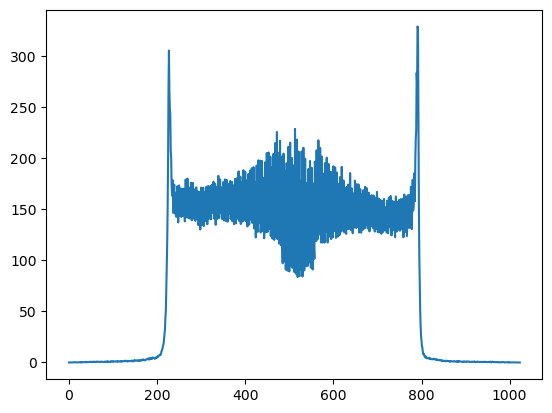

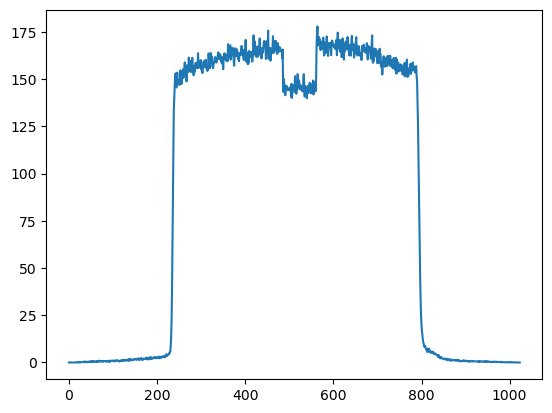

In [21]:
# Integrated over x, function of y
proj_y = np.sum(flood_norm, axis = 1)
y_range = np.arange(0,1024,1)
plt.plot(y_range, proj_y)
plt.show()

# Integrated over y, function of x
proj_x = np.sum(flood_norm, axis = 0)
x_range = np.arange(0,1024,1)
plt.plot(x_range, proj_x)
# plt.xlim((400,600))

## Histogram of pixel efficiencies
Verify that the statistics of efficiencies are reasonable: no extraordinarily high values etc.

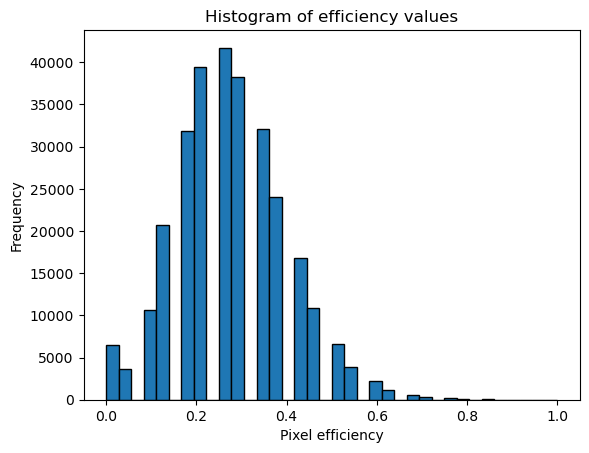

In [22]:
# Flatten the 2D array to a 1D array
active_flood = flood_norm[rect_slice((512, 512), N_eff_pixel)]
flat_array = (active_flood).flatten()

# Plot histogram
plt.hist(flat_array, bins=36, edgecolor='black')
plt.xlabel('Pixel efficiency')
plt.ylabel('Frequency')
plt.title('Histogram of efficiency values')
plt.show()

## Synthesize full efficiency map (temporary)
Currently, no flood measurement is available that can characterize the full detector so make up the values in the beamstop area for now by copying other values. NOT FOR USE IN ACTUAL DATA REDUCTIONS.

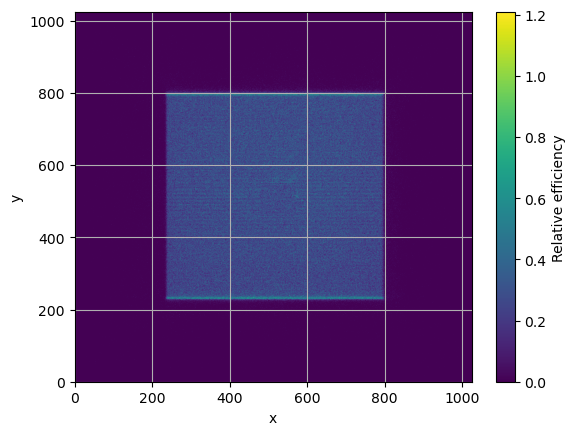

In [23]:
flood_norm_synth = np.copy(flood_norm)
offset = 15
flood_norm_synth[rect_slice((beamstop_x, beamstop_y),beamstop_w+offset)] = flood_norm_synth[rect_slice((beamstop_x, beamstop_y+beamstop_w+offset+10),beamstop_w+offset)]
plot_image(flood_norm_synth, "Relative efficiency")

In [24]:
np.savetxt('pixel-efficiency.txt.gz',flood_norm_synth)